In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("updated_cleaned_dataset_2.csv")

In [3]:
df.shape

(3113, 37)

In [4]:
columns_to_drop = [
    'CurrentSmoker_Missing',
    'EverDrank',  # redundant
    'DIQ050',     # insulin use (already accounted for in T2D filters)
    'DIQ070',     # diabetes pill use
    'FastingGlucose',    # HOMA-B multicolinearity
    'FastingInsulin',    # HOMA-B multicolinearity
    'SEQN',       #  no longer needed
    'likely_type1',
    'HasDiabetes' # t2d column already there
]

# Drop columns
df = df.drop(columns=columns_to_drop)

In [5]:
columns_to_drop_2 = [
    'SerumCreatinine',
    'CurrentSmoker_Not at all',
    'DrinkFrequency'
]

# Drop columns
df = df.drop(columns=columns_to_drop_2)

In [6]:
df = df.drop(columns=['LBXSATSI'], errors='ignore')

In [7]:
df.shape

(3113, 24)

In [8]:
list(df.columns.values)

['BUN',
 'EverSmoked100',
 'AvgDrinksPerDay',
 'Age',
 'Gender',
 'Education',
 'IncomeToPovertyRatio',
 'ACR',
 'T2D',
 'IncomeMissing',
 'HOMA_B',
 'CurrentSmoker_2.0',
 'CurrentSmoker_3.0',
 'SurveyCycle_2001-2002',
 'SurveyCycle_2003-2004',
 'SurveyCycle_2005-2006',
 'SurveyCycle_2007-2008',
 'SurveyCycle_2009-2010',
 'SurveyCycle_2011-2012',
 'SurveyCycle_2013-2014',
 'SurveyCycle_2015-2016',
 'SurveyCycle_2017-2020',
 'EverDrank_Label_Drinks Alcohol',
 'eGFR']

In [9]:
columns_to_drop_3 = [
    'T2D',
    'IncomeMissing'
]

df = df.drop(columns=columns_to_drop_3)

In [11]:
df['AvgDrinksPerDay'] = df['AvgDrinksPerDay'].clip(upper=20)

In [12]:
df['ACR_log'] = np.log1p(df['ACR'])  # log1p handles 0 safely
df.drop(columns=['ACR'], inplace=True)

In [14]:
features = [
    'BUN', 'eGFR', 'ACR_log',                     
    'CurrentSmoker_2.0', 'CurrentSmoker_3.0',  
    'AvgDrinksPerDay', 'EverDrank_Label_Drinks Alcohol',
    'Age', 'Gender', 'Education', 'IncomeToPovertyRatio'
]
target = 'HOMA_B'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
numerical_features = ['BUN', 'Age', 'eGFR', 'ACR_log', 'AvgDrinksPerDay']

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

In [16]:
df.shape

(3113, 22)

In [18]:
df.to_csv('ready_to_model_2.csv', index=False)

In [30]:
X_train_const = sm.add_constant(X_train_scaled)
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 HOMA_B   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.259
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           2.95e-08
Time:                        17:30:31   Log-Likelihood:                -7524.0
No. Observations:                2490   AIC:                         1.507e+04
Df Residuals:                    2478   BIC:                         1.514e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [31]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [32]:
y_pred = tree_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Decision Tree - MSE: {mse:.2f}, R^2: {r2:.2f}")

Decision Tree - MSE: 51.63, R^2: -0.33


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'min_samples_split': 10}


In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest R²: -0.06


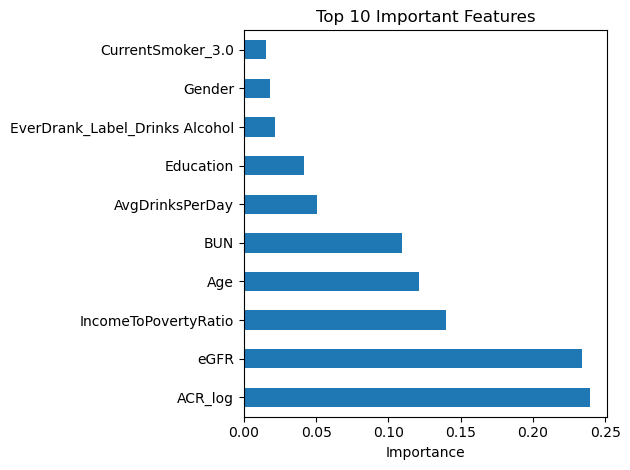

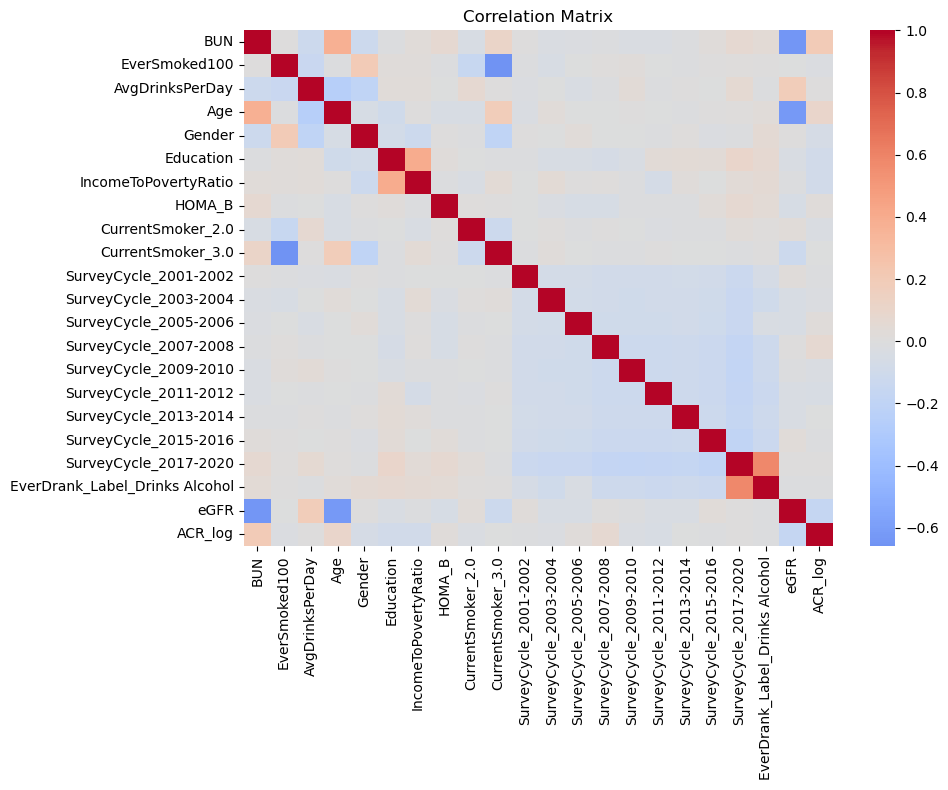

In [35]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [36]:
# 1. Try log-transforming the target to reduce skewness
y_train_log = np.log1p(y_train)  # log(1 + y)
y_test_log = np.log1p(y_test)

# 2. Refit model on log-transformed target
tree_model = DecisionTreeRegressor(max_depth=3, min_samples_split=18, random_state=42)
tree_model.fit(X_train_scaled, y_train_log)

# 3. Predict and back-transform
y_pred_log = tree_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # inverse of log1p

# 4. Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Log-Transformed Tree MSE: {mse:.2f}, R²: {r2:.2f}")


Log-Transformed Tree MSE: 40.22, R²: -0.04


In [37]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train_scaled, y_train_log)

y_pred_log = gb_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"GBM MSE: {mse:.2f}, R²: {r2:.2f}")

GBM MSE: 40.65, R²: -0.05


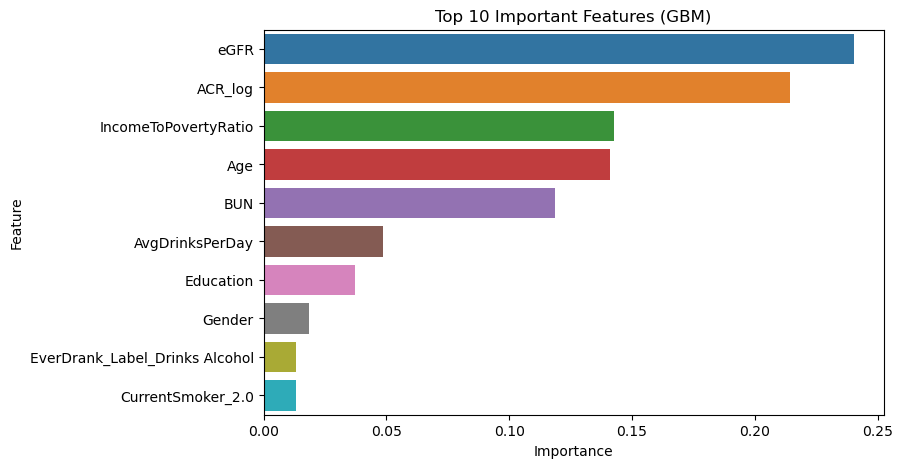

In [38]:
importances = gb_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features (GBM)')
plt.show()

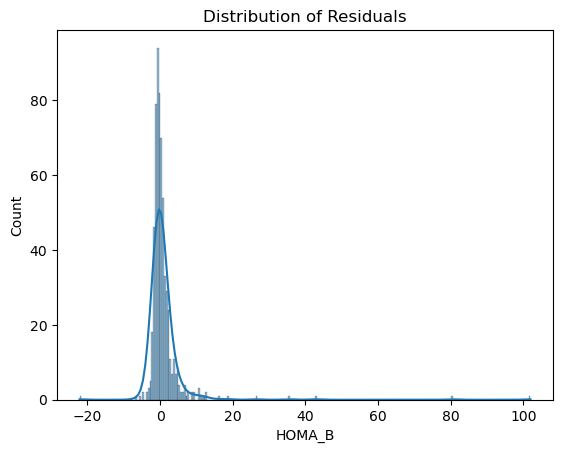

In [39]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

# 1. Select features and target
features = [
    'BUN', 'eGFR', 'ACR_log',
    'CurrentSmoker_2.0', 'CurrentSmoker_3.0',
    'AvgDrinksPerDay', 'EverDrank_Label_Drinks Alcohol',
    'Age', 'Gender', 'Education', 'IncomeToPovertyRatio'
]
target = 'HOMA_B'

# 2. Train/Test Split
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scale numerical features
numerical_features = ['BUN', 'Age', 'eGFR', 'ACR_log', 'AvgDrinksPerDay']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# 4. Apply Box-Cox to target
y_train_bc, fitted_lambda = boxcox(y_train)
print(f"Box-Cox Lambda: {fitted_lambda}")

# 5. Fit Decision Tree on transformed target
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train_bc)

# 6. Predict and inverse-transform Box-Cox
y_pred_bc = tree_model.predict(X_test_scaled)
# Use inverse Box-Cox
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power((y * lmbda) + 1, 1 / lmbda)

y_pred = inv_boxcox(y_pred_bc, fitted_lambda)

# 7. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Box-Cox Transformed Tree MSE: {mse:.2f}, R²: {r2:.2f}")


Box-Cox Lambda: -0.02527040955832148
Box-Cox Transformed Tree MSE: 55.75, R²: -0.44


In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train_bc)
knn_pred_bc = knn.predict(X_test_scaled)
knn_pred = inv_boxcox(knn_pred_bc, fitted_lambda)
print("KNN MSE:", mean_squared_error(y_test, knn_pred))

# MLP
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train_bc)
mlp_pred_bc = mlp.predict(X_test_scaled)
mlp_pred = inv_boxcox(mlp_pred_bc, fitted_lambda)
print("MLP MSE:", mean_squared_error(y_test, mlp_pred))

KNN MSE: 40.65326322718407
MLP MSE: 44.018422273707806


In [47]:
def create_data_dictionary(df):
    df_dict = {
        "Feature Name": [],
        "Data Type": [],
        "Missing Values": [],
        "Unique Values": [],
        "Description": [],
    }

    # Feature descriptions for your current dataset
    feature_descriptions = {
        "BUN": "Blood urea nitrogen (mg/dL), marker of kidney function",
        "eGFR": "Estimated glomerular filtration rate (mL/min/1.73m²), a calculated measure of kidney function based on serum creatinine, age, and sex.", 
        "ACR_log": "Log of ACR to calculate urine albumin-to-creatinine ratio (mg/g), marker of kidney damage",
        "CurrentSmoker_2.0": "Current smoking status: some days (dummy variable)", 
        "CurrentSmoker_3.0": "Current smoking status: not at all (dummy variable)",
        "AvgDrinksPerDay": "Average number of alcoholic drinks per day over past 12 months",
        "EverDrank_Label_Drinks Alcohol": "Label indicating whether participant drinks alcohol",
        "Age": "Age in years at time of screening",
        "Gender": "Gender (1 = Male, 2 = Female)", 
        "Education": "Education level (1 = Less than 9th grade to 5 = College graduate or above)",
        "IncomeToPovertyRatio": "Ratio of family income to poverty level"
    }

    # Loop through each column in the DataFrame
    for column in df.columns:
        df_dict["Feature Name"].append(column)
        df_dict["Data Type"].append(df[column].dtype)
        df_dict["Missing Values"].append(df[column].isnull().sum())
        df_dict["Unique Values"].append(df[column].nunique())
        df_dict["Description"].append(feature_descriptions.get(column, "No description available"))

    return pd.DataFrame(df_dict)
# Optional: remove a column if it exists
df = df.drop(columns=['Calculated_Diff'], errors='ignore')

# Create and view the data dictionary
data_dict_df = create_data_dictionary(df)
data_dict_df

,Feature Name,Data Type,Missing Values,Unique Values,Description
0,BUN,float64,0,51,"Blood urea nitrogen (mg/dL), marker of kidney ..."
1,EverSmoked100,float64,0,4,No description available
2,AvgDrinksPerDay,float64,0,16,Average number of alcoholic drinks per day ove...
3,Age,float64,0,68,Age in years at time of screening
4,Gender,float64,0,2,"Gender (1 = Male, 2 = Female)"
5,Education,float64,0,7,Education level (1 = Less than 9th grade to 5 ...
6,IncomeToPovertyRatio,float64,0,464,Ratio of family income to poverty level
7,HOMA_B,float64,0,2920,No description available
8,CurrentSmoker_2.0,int64,0,2,Current smoking status: some days (dummy varia...
9,CurrentSmoker_3.0,int64,0,2,Current smoking status: not at all (dummy vari...


In [48]:
def create_data_dictionary(df):
    df_dict = {
        "Feature Name": [],
        "Data Type": [],
        "Missing Values": [],
        "Unique Values": [],
        "Description": [],
    }

    # List of columns you want to exclude from the data dictionary
    exclude_columns = ['EverSmoked100', 'SurveyCycle_2001-2002', 'SurveyCycle_2003-2004', 'SurveyCycle_2005-2006', 'SurveyCycle_2007-2008', 'SurveyCycle_2009-20010', 'SurveyCycle_2011-2012', 'SurveyCycle_2013-2014', 'SurveyCycle_2015-2016', 'SurveyCycle_2017-2020', 'HOMA_B_quartile']  # Replace with actual column names

    # Feature descriptions for your current dataset
    feature_descriptions = {
        "BUN": "Blood urea nitrogen (mg/dL), marker of kidney function",
        "eGFR": "Estimated glomerular filtration rate (mL/min/1.73m²), a calculated measure of kidney function based on serum creatinine, age, and sex.", 
        "ACR_log": "Log of ACR to calculate urine albumin-to-creatinine ratio (mg/g), marker of kidney damage",
        "CurrentSmoker_2.0": "Current smoking status: some days (dummy variable)", 
        "CurrentSmoker_3.0": "Current smoking status: not at all (dummy variable)",
        "AvgDrinksPerDay": "Average number of alcoholic drinks per day over past 12 months",
        "EverDrank_Label_Drinks Alcohol": "Label indicating whether participant drinks alcohol",
        "Age": "Age in years at time of screening",
        "Gender": "Gender (1 = Male, 2 = Female)", 
        "Education": "Education level (1 = Less than 9th grade to 5 = College graduate or above)",
        "IncomeToPovertyRatio": "Ratio of family income to poverty level"
    }

    # Loop through each column in the DataFrame
    for column in df.columns:
        if column in exclude_columns:
            continue
        df_dict["Feature Name"].append(column)
        df_dict["Data Type"].append(df[column].dtype)
        df_dict["Missing Values"].append(df[column].isnull().sum())
        df_dict["Unique Values"].append(df[column].nunique())
        df_dict["Description"].append(feature_descriptions.get(column, "No description available"))

    return pd.DataFrame(df_dict)

# Optional: remove a column if it exists
df = df.drop(columns=['Calculated_Diff'], errors='ignore')

# Create and view the data dictionary
data_dict_df = create_data_dictionary(df)
data_dict_df

,Feature Name,Data Type,Missing Values,Unique Values,Description
0,BUN,float64,0,51,"Blood urea nitrogen (mg/dL), marker of kidney ..."
1,AvgDrinksPerDay,float64,0,16,Average number of alcoholic drinks per day ove...
2,Age,float64,0,68,Age in years at time of screening
3,Gender,float64,0,2,"Gender (1 = Male, 2 = Female)"
4,Education,float64,0,7,Education level (1 = Less than 9th grade to 5 ...
5,IncomeToPovertyRatio,float64,0,464,Ratio of family income to poverty level
6,HOMA_B,float64,0,2920,No description available
7,CurrentSmoker_2.0,int64,0,2,Current smoking status: some days (dummy varia...
8,CurrentSmoker_3.0,int64,0,2,Current smoking status: not at all (dummy vari...
9,SurveyCycle_2009-2010,int64,0,2,No description available
